This code is used for Bin Picking. Objects are detected bt Mask-RCNN. Dataset is synthetic data is generated from Blender Software.

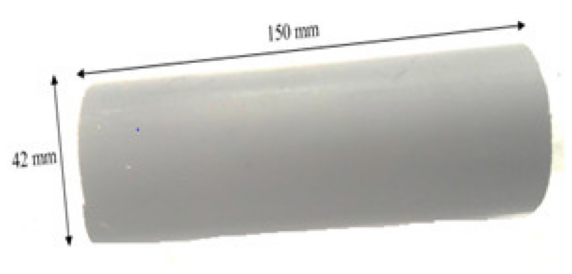

In [65]:
# Object for Bin Picking
image = plt.imread('/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/IMG_1639997346467_1640407514883.jpg')
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(image)

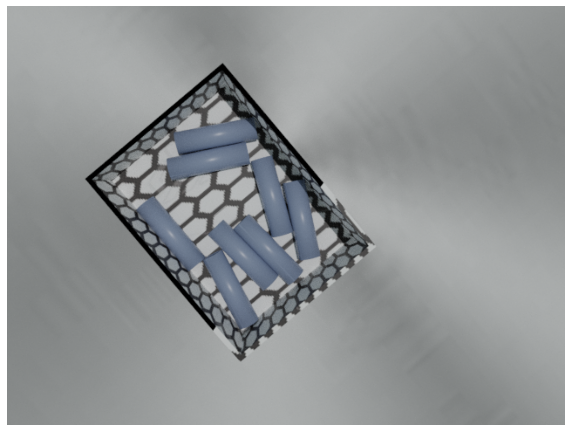

In [64]:
# Synthetic Image
image = plt.imread('/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Dataset/train/image/Image_499.png')
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(image)

In [ ]:
# Connect wih Google Drive
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


#Install MaskRCNN from scratch

In [ ]:
# Chuyen den thu muc chua Mask RCNN
%cd /content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Mask_RCNN/Mask-RCNN-TF1 

/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Mask_RCNN/Mask-RCNN-TF1


In [ ]:
# Mask_RCNN TF 1.x
!git clone https://github.com/matterport/Mask_RCNN.git 

# Mask_RCNN TF 2.x
#!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

In [ ]:
%cd /content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Mask_RCNN/Mask-RCNN-TF1/Mask_RCNN
!sudo python setup.py install

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
# Download COCO weights
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

# TRAINING

##Install package

In [ ]:
#!pip install open3d

In [ ]:
!pip uninstall keras-nightly
!pip install h5py==2.10.0

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.15

##Object Detection Model

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Dataset' 
model_dir = '/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Model' 

###Import library

In [ ]:
%cd /content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Mask_RCNN/Mask-RCNN-TF1/Mask_RCNN

/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Mask_RCNN/Mask-RCNN-TF1/Mask_RCNN


In [ ]:
# import basic libraries
import os
from os import listdir
import sys
import json
import datetime
import time
# import advance libraries
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# import mask rcnn libraries
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

# import matplotlib library
import matplotlib.pyplot as plt

# import numpy libraries
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pandas as pd
# import keras libraries
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# inline matplotlib
%matplotlib inline

Using TensorFlow backend.


###Process Dataset

In [ ]:
class CustomDataset(Dataset):

    # load_dataset function is used to load the train and test dataset
    def load_dataset(self, dataset_dir, subset):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        # self.add_class('source', 'class id', 'class name')
        self.add_class("dataset", 1, "PipeI")
      
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset) # will delete when out of load_dataset

        # load annotations using json.load()
        annotations1 = json.load(open(os.path.join(dataset_dir, "annotation.json")))
        
        # convert annotations1 into a list
        annotations = list(annotations1.values()) 

        # we only require the regions in the annotations
        annotations = [a for a in annotations if a['maskimage'] and a['num_masks'] > 0]


        # Add images
        for a in annotations:
          
          mask = a["maskimage"]
          num_masks = a["num_masks"]
          objects = a["objects"]
          
          # create a dictionary {name_of_class: class_id} remember background has id 0
          name_dict = {"PipeI": 1}
            
          # all the ids/classes in a image
          num_ids = [name_dict[a] for a in objects]
            
          # you can print these ids
          # print("numids",num_ids)
            
          # read image and get height and width
          #image_path = os.path.join(dataset_dir + 'image/', a['filename'])
          image_path = dataset_dir + '/image/' + a['filename']
          image = skimage.io.imread(image_path)
          height, width = image.shape[:2]
            
          # add image to the dataset
          self.add_image(
              "dataset",
              image_id=a['filename'],
              path=image_path,
              width=width, height=height,
              mask=mask,
              num_masks=num_masks,
              num_ids=num_ids,
              subset=subset    # to known where show mask
              )
        
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances        
    def load_mask(self, image_id):
           
        # info points to the current image_id
        info = self.image_info[image_id]
        mask_dir = os.path.join(dataset_dir, info["subset"]) # dataset_dir above is erased
        # for cases when source is not damage
        if info["source"] != "dataset":
            return super(self.__class__, self).load_mask(image_id)
        
        # get the class ids in an image
        num_ids = info['num_ids']
        
        # we create len(info["polygons"])(total number of polygons) number of masks of height 'h' and width 'w'
        mask = np.zeros([info["height"], info["width"], info["num_masks"]],
                        dtype=np.uint8)
        maskimage = info["mask"] 
        mask_path = mask_dir + '/mask/' + maskimage            
        mask_full = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # we loop over all polygons and generate masks (polygon mask) and class id for each instance
        # masks can have any shape as we have used polygon for annotations
        # for example: if 2.jpg have four objects we will have following masks and class_ids
        # 000001100 000111000 000001110
        # 000111100 011100000 000001110
        # 000011111 011111000 000001110
        # 000000000 111100000 000000000
        #    1         2          3    <- class_ids
        for i in range(info["num_masks"]):
          mask[mask_full==(i+1), i] = 1
            
        # return masks and class_ids as array
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
    
    # this functions takes the image_id and returns the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "dataset":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

       


###Config

In [ ]:
# damage configuration class, you can change values of hyper parameters here
class CustomConfig(Config):
    # name of the configuration
    NAME = "custom_cfg"
    
    #  background class + 20 classes
    NUM_CLASSES = 1 + 1
    
    # steps per epoch and minimum confidence
    STEPS_PER_EPOCH = 500
    
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640
    
    # validation steps
    VALIDATION_STEPS = 200
    
    # number of Region of Interest generated per image  
    TRAIN_ROIS_PER_IMAGE = 500 

    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES =  (16, 32, 64, 128)                          
    RPN_ANCHOR_RATIOS = [0.333, 1, 3]  

### Training

#### With augmentation

In [ ]:
import imgaug.augmenters as iaa

In [ ]:
augment_ops = iaa.Sometimes(0.5, 
                 [ iaa.OneOf([
                              iaa.GaussianBlur(sigma=(0, 1.0)),
                              iaa.MedianBlur(k=(3, 11)),
                              iaa.AverageBlur(k=(2, 7)),
                              iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.08*255), per_channel=0.5),
                              iaa.ImpulseNoise(0.08),
                              iaa.SaltAndPepper(0.08),
                              iaa.Add((-10, 10), per_channel=0.5),
                             ]
                            ),
                 ])


In [ ]:
image = load_img("/content/gdrive/MyDrive/THESIS/Dataset_3class/train/image/Image_1.png")
image = img_to_array(image)
image = image.astype(np.uint8)
image_aug = augment_ops(images = image)
plt.imshow(image_aug)

In [ ]:
# prepare train set
train_set = CustomDataset()
train_set.load_dataset(dataset_dir, "train")
train_set.prepare()

# validation/test
val_set = CustomDataset()
val_set.load_dataset(dataset_dir, "val")
val_set.prepare()

# load damage config
config = CustomConfig()

# define the model
model = MaskRCNN(mode='training', model_dir=model_dir, config=config) # model_dir content/gdrive/MyDrive


# load weights mscoco model weights
weights_path = '/content/gdrive/MyDrive/objectdetection/Mask_RCNN/mask_rcnn_coco.h5'

# load the model weights
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

start_time = time.time()
# start the training of model
# you can change epochs and layers (head or all) 
model.train(train_set,
            val_set,
            learning_rate=config.LEARNING_RATE,
            epochs=12,
            layers='heads',
            augmentation = augment_ops
           )
end_time = time.time()
hist = model.keras_model.history.history
print("Training finished")

#### Without augmentation

In [ ]:
# prepare train set
train_set = CustomDataset()
train_set.load_dataset(dataset_dir, "train")
train_set.prepare()

# validation/test
val_set = CustomDataset()
val_set.load_dataset(dataset_dir, "val")
val_set.prepare()

# load damage config
config = CustomConfig()

# define the model
model = MaskRCNN(mode='training', model_dir=model_dir, config=config) # model_dir content/gdrive/MyDrive


# load weights mscoco model weights
#weights_path = '/content/gdrive/MyDrive/objectdetection/Mask_RCNN/mask_rcnn_coco.h5'   # If training from scratch
weights_path  = '/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Model/custom_cfg20211010T0339/mask_rcnn_custom_cfg_0030.h5'   # If continue training

# load the model weights
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

start_time = time.time()

# start the training of model
# you can change epochs and layers (head or all) 
model.train(train_set, 
            val_set, 
            learning_rate=config.LEARNING_RATE,
            epochs=40, 
            layers='heads')
end_time = time.time()
hist = model.keras_model.history.history
print("Training finished")

#### History

In [ ]:
epochs = range(11, 11+len(next(iter(hist.values()))))
loss_history= pd.DataFrame(hist, index=epochs)

In [ ]:
print(loss_history['loss'])

In [ ]:
loss_history.to_csv('/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Model/loss_history_model_longpipe_epoch_11to20.csv')

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.plot(epochs, hist["loss"], label="Training loss")
plt.plot(epochs, hist["val_loss"], label="Validation loss")
plt.legend()
plt.show()

# EVALUATION MODEL

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_iou(a, b, epsilon=1e-5):
    """ 
    Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.
    Args: 
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero
    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

Re-starting from epoch 5
Test mAP: 0.704


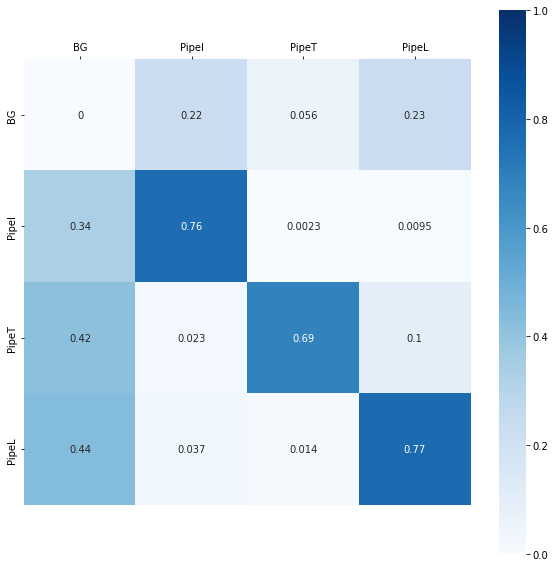

In [ ]:
# we define a prediction configuration 
class PredictionConfig(Config):
    NAME = "thesis"
    NUM_CLASSES = 3 + 1
    #DETECTION_MIN_CONFIDENCE = 0.85
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640
    RPN_ANCHOR_SCALES = (32, 48, 64, 128)    # need tuning  [32, 54, 64, 128, 256]
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]  

    
# evaluate_model is used to calculate mean Average Precision of the model
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    mAP = mean(APs)
    return mAP

# Confusion matrix when more than 2 class (not including BG)
def confusion_matrix(dataset, model, cfg):
    matrix = np.zeros(shape=(200,4,4))
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]
        
        for i, true_box in enumerate(gt_bbox):
          max_iou = 0.0
          max_idx = 0
          for j, pre_box in enumerate(r["rois"]):
            iou = get_iou(true_box, pre_box)
            if iou > max_iou:
              max_iou = iou
              max_idx = j
          if max_iou < 0.5:
            matrix[image_id, gt_class_id[i], 0] += 1
          else:
            matrix[image_id, gt_class_id[i], r["class_ids"][max_idx]] += 1
            r["class_ids"][max_idx] = -1
        for class_id in r["class_ids"]:
          if class_id > 0:
            matrix[image_id, 0, class_id] += 1

    return matrix


# Train dataset
#train_set = CustomDataset()
#train_set.load_dataset(dataset_dir, "train")
#train_set.prepare()

# Validation dataset
val_set = CustomDataset()
val_set.load_dataset(dataset_dir, "val")
val_set.prepare()

# Test dataset
#test_set = CustomDataset()
#test_set.load_dataset(dataset_dir, "test")
#test_set.prepare()

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir=model_dir, config=cfg)
# load model weights
model.load_weights('/content/gdrive/MyDrive/THESIS/model_3class_3/custom_cfg20211130T0402/mask_rcnn_custom_cfg_0005.h5', by_name=True)

# evaluate model on train dataset
#train_mAP = evaluate_model(train_set, model, cfg)
#print("Train mAP: %.3f" % train_mAP)

# evaluate model on train dataset
val_mAP = evaluate_model(val_set, model, cfg)

# evaluate model on test dataset
#test_mAP = evaluate_model(test_set, model, cfg)

matrix = confusion_matrix(val_set, model, cfg)
matrix_full = np.sum(matrix, axis=0)
normalized_matrix = matrix_full / matrix_full.astype(np.float).sum(axis=1)

print("Test mAP: %.3f" % val_mAP)
plt.figure(figsize = (10,10))
ax = plt.gca()
label=['BG','PipeI','PipeT', 'PipeL']
ax.xaxis.set_ticks_position("top")

plt.show(sns.heatmap(data=normalized_matrix,vmin=0,vmax=1.0,cmap='Blues',annot=True,xticklabels=label,yticklabels=label,square=True))


# PREDICT(INTERFERENCE)

In [ ]:
# define a configuration for the model
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "pipe_detect"
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640

    DETECTION_MAX_INSTANCES = 30
    MAX_GT_INSTANCES = 50
    DETECTION_MIN_CONFIDENCE = 0.85

    RPN_ANCHOR_SCALES = (16, 32, 64, 128)   
    RPN_ANCHOR_RATIOS = [0.333, 1, 3]            

# load prediction configuration
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir=model_dir, config=cfg) 

# load model weights
model_path  = '/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Model/custom_cfg20211010T0339/mask_rcnn_custom_cfg_0040.h5'
model.load_weights(model_path, by_name=True) 









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 40


Processing 1 images
image                    shape: (480, 640, 3)         min:   11.00000  max:  193.00000  float32
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:   89.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102000, 4)        min:   -0.17356  max:    1.12348  float32


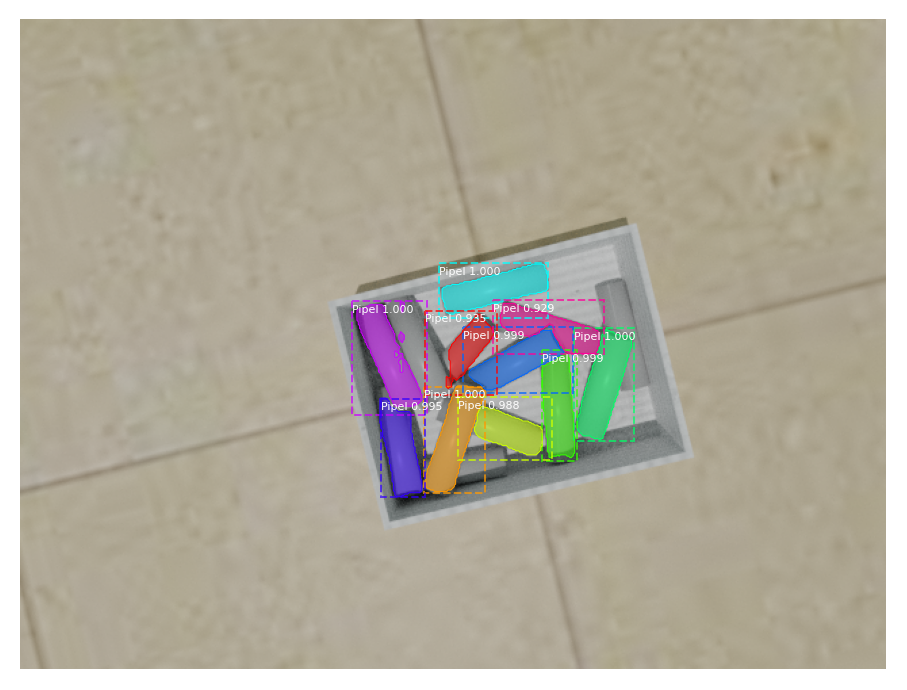

In [ ]:
# Synthetic Image
# load image and convert image to array
image = load_img("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Dataset/val/image/Image_0.png")
image = img_to_array(image)

# call the detect method on image
start = time.time()
results = model.detect([image], verbose=1)
end = time.time()
# class_names = ['BG', class_id_1_name, class_id_2_name]
class_names = ['BG', 'PipeI']
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102000, 4)        min:   -0.17356  max:    1.12348  float32


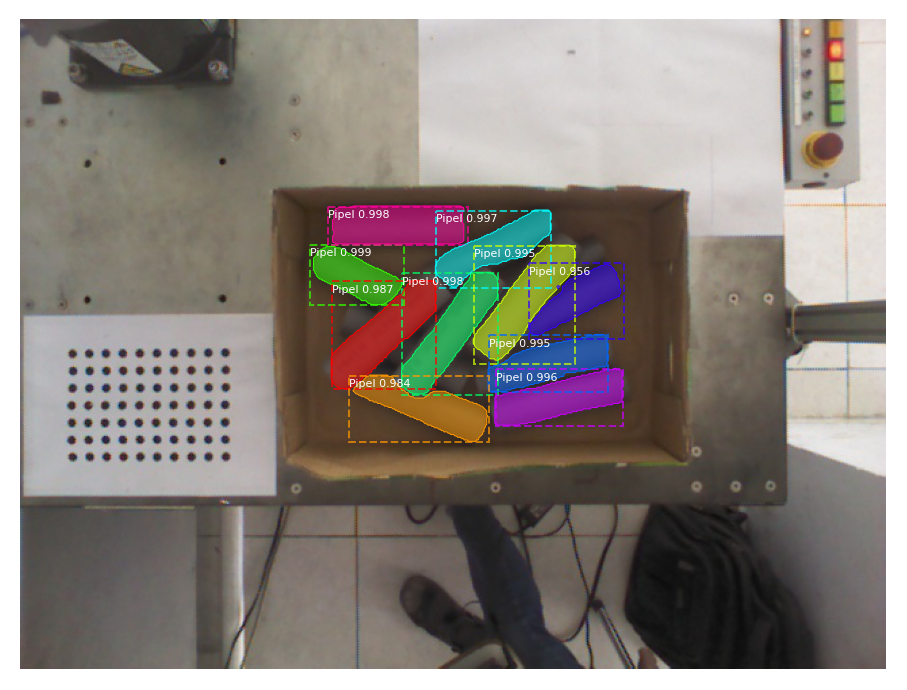

In [ ]:
# Real Image
# load image and convert image to array
image = load_img('/content/pipe1.jpg')
image = img_to_array(image)

# call the detect method on image
start = time.time()
results = model.detect([image], verbose=1)
end = time.time()
# class_names = ['BG', class_id_1_name, class_id_2_name]
class_names = ['BG', 'PipeI']
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

# DETECT FROM POINTCLOUD

In [ ]:
!pip install open3d

## Read RGB Image from Point Cloud .pcd

In [ ]:
%matplotlib inline
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

True

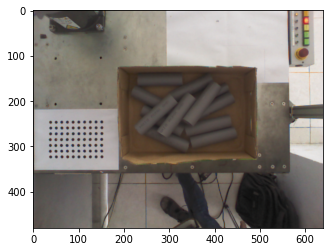

In [ ]:
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
rgb_ = np.asarray(pcd.colors)
rgb_ = rgb_*255 
rgb_ = np.array(rgb_, dtype=np.uint8)
image = np.zeros((480,640,3), dtype = np.uint8)
for row in range(480):
  for col in range(640):
    pcd_idx = 640*row + col
    image[row,col,0] = int(rgb_[pcd_idx][0])
    image[row,col,1] = int(rgb_[pcd_idx][1])
    image[row,col,2] = int(rgb_[pcd_idx][2])

plt.imshow(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/pipe1.jpg', image)

## Detect Image

In [ ]:
# define a configuration for the model
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "pipe_detect"
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
   
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640

    DETECTION_MAX_INSTANCES = 30
    MAX_GT_INSTANCES = 50
    DETECTION_MIN_CONFIDENCE = 0.85

    RPN_ANCHOR_SCALES = (16, 32, 64, 128)   
    RPN_ANCHOR_RATIOS = [0.333, 1, 3]             

# load prediction configuration
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir=model_dir, config=cfg) 

# load model weights
model_path  = '/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/Model/custom_cfg20211010T0339/mask_rcnn_custom_cfg_0040.h5'
model.load_weights(model_path, by_name=True) 

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102000, 4)        min:   -0.17356  max:    1.12348  float32


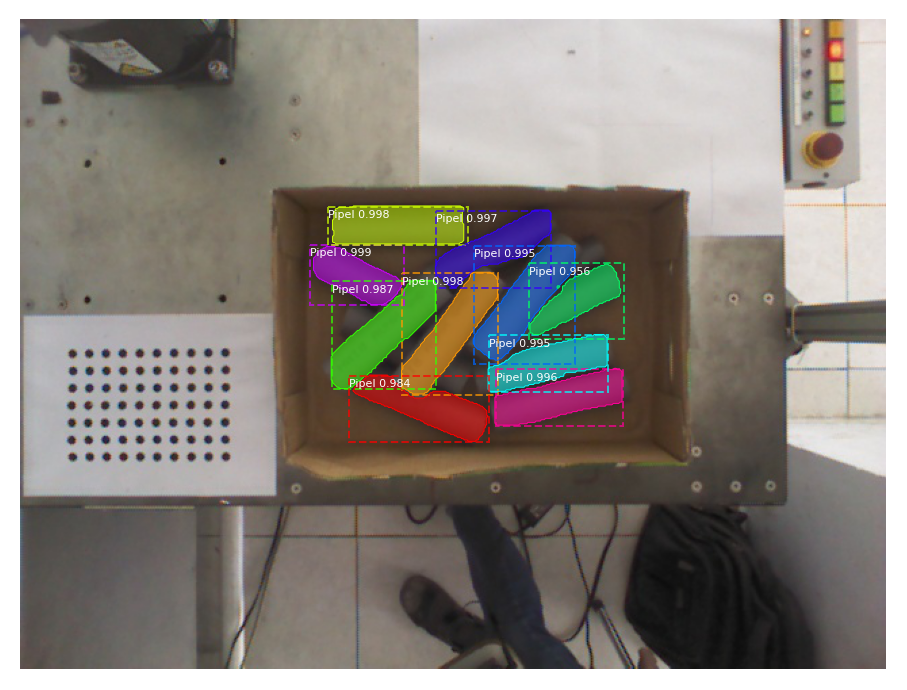

In [ ]:
# load image and convert o array
image = load_img('/content/pipe1.jpg')
image = img_to_array(image)

# call the detect method on image
start = time.time()
results = model.detect([image], verbose=1)
end = time.time()
# class_names = ['BG', class_id_1_name, class_id_2_name]
class_names = ['BG', 'PipeI']
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

In [ ]:
for i in range(r['masks'].shape[2]):
  mask = r['masks'][:,:,i]
  mask = np.array(mask, dtype = np.uint8)
  cv2.imwrite('/content/mask_' + str(i) + '.jpg', mask)

## Draw 2 axis of objects

In [ ]:
import numpy as np
from math import atan2, cos, sin, sqrt, pi
import cv2
import matplotlib.pyplot as plt

In [ ]:
colors_U = np.array([[190,93,37], [128,128,128], [120,190,37], [37,190,93], [37,174,190], 
            [56,37,190], [126,37,190], [190,37,185], [190,37,115], [190,37,40]], dtype = np.uint8)
colors_F = colors_U/255.0

True

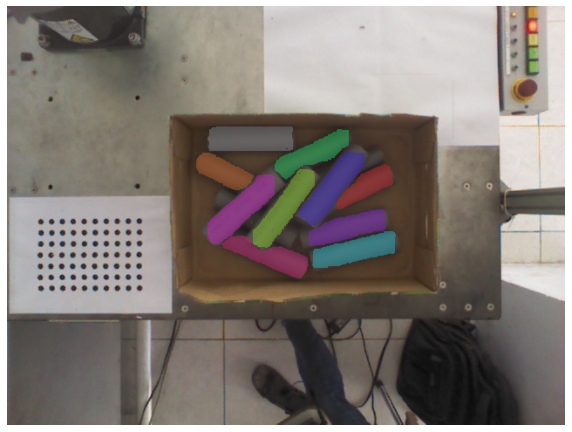

In [ ]:
image = cv2.imread('/content/pipe1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_ = image

for i in range(10): 
  mask = cv2.imread('/content/mask_' + str(i) +'.jpg', 0)
  r, c = np.where(mask==1)
  for j in range(3):
    image_[r,c,j] =  0.5*colors_U[i][j] + 0.5*image_[r,c,j] 

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(image_)

image_ = cv2.cvtColor(image_, cv2.COLOR_RGB2BGR)
cv2.imwrite('/content/pipe1_result1.jpg', image_)

In [ ]:
# load image
img = cv2.imread('/content/pipe1_result1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

contours = []
for m in range(10):
  mask = cv2.imread('/content/mask_' + str(m) + '.jpg', 0)
  contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  contours.append(contour)

In [ ]:
def get_orientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    cv2.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    draw_axis(img, cntr, p1, (250, 0, 0), 2)
    draw_axis(img, cntr, p2, (0, 250, 0), 6)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    return angle

In [ ]:
def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

In [ ]:
angles = []
for contour in contours:
  for i,c in enumerate(contour):
    # area of each contour
    area = cv2.contourArea(c)
    # ignore contour which is too small or large
    if area < 1e2 or 1e5 < area:
      continue
    # draw each contour only for visualization
    #cv2.drawContours(img, contours, i, (0, 0, 255), 2)
    # find orientation of each shape
    angle = get_orientation(c,img)
    angles.append(angle)

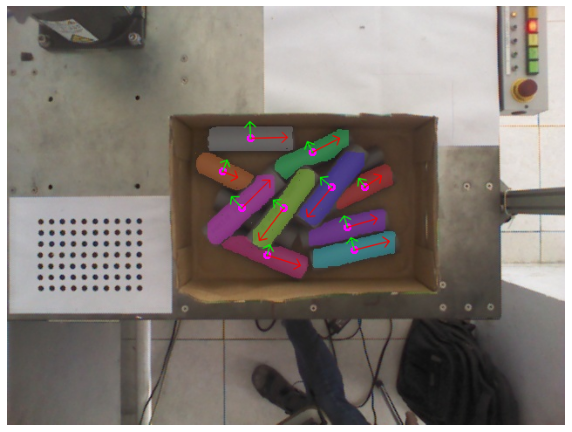

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(img)

In [ ]:
plt.imsave('/content/pipe1_result2.jpg', img)

##  Outlier Removal

In [ ]:
colors_U = np.array([[190,93,37], [128,128,128], [120,190,37], [37,190,93], [37,174,190], 
            [56,37,190], [126,37,190], [190,37,185], [190,37,115], [190,37,40]], dtype = np.uint8)
colors_F = colors_U/255.0

### Before remove

WARNING - 2021-12-25 03:24:56,366 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:24:56,393 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:24:56,418 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array 

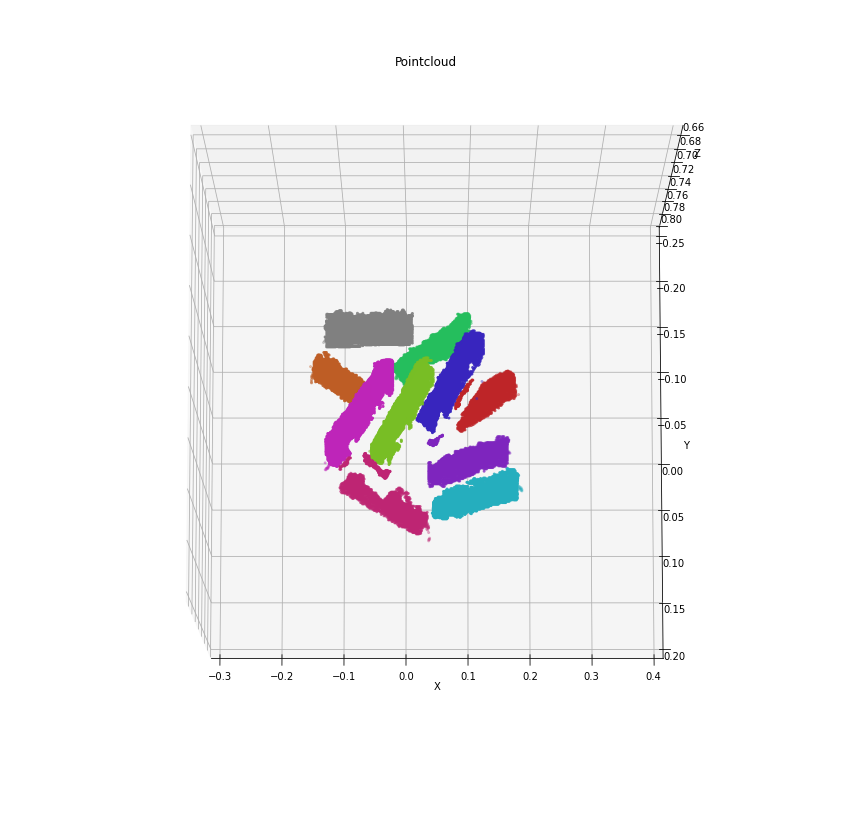

In [ ]:
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
xyz = np.asarray(pcd.points)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-100, -90)  # Setting viewpoint, example values (-150,-90), (-100,-90)
ax.set_title("Pointcloud")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-0.3,0.4)
ax.set_ylim(-0.25,0.2)
ax.set_zlim(0.65,0.8)

for i in range(0,10):
  mask = cv2.imread('/content/mask_'+ str(i)+ '.jpg', 0)
  r, c = np.where(mask==1)
  idx = 640*r + c
  obj = xyz[idx]
  obj_ = []
  for o in obj:
    if str(o[0])=='nan' or str(o[1])=='nan' or str(o[1])=='nan':
      continue
    obj_.append(o)
  obj_ = np.asarray(obj_)
  
  ax.scatter(obj_[:,0], obj_[:,1], obj_[:,2], c = colors_F[i], s = 4.0 )  # marker = x
  
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(obj_, mean)
  
  X = mean[0][0]
  Y = mean[0][1]
  Z = mean[0][2]
  U = X + eigenvectors[0][0]
  V = Y + eigenvectors[0][1]
  W = Z + eigenvectors[0][2]
  
  X1 = mean[0][0]
  Y1 = mean[0][1]
  Z1 = mean[0][2]
  U1 = X1 + eigenvectors[1][0]
  V1 = Y1 + eigenvectors[1][1]
  W1 = Z1 + eigenvectors[1][2]

  X2 = mean[0][0]
  Y2 = mean[0][1]
  Z2 = mean[0][2]
  U2 = X2 + eigenvectors[2][0]
  V2 = Y2 + eigenvectors[2][1]
  W2 = Z2 + eigenvectors[2][2]

plt.show()

### After remove

In [ ]:
# Xac dinh thu tu gap theo do cao voi trong tam tinh tu XYZ
# Define pick order according to centers calculating from XYZ 
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
xyz = np.asarray(pcd.points)
means = []
for i in range(10):
  mask = cv2.imread('/content/mask_' + str(i) + '.jpg', 0)
  r, c = np.where(mask==1)
  idx = 640*r + c
  obj = xyz[idx]
  obj_ = []
  
  # Remove nan values
  for o in obj:
    if str(o[0])=='nan' or str(o[1])=='nan' or str(o[1])=='nan':
      continue
    obj_.append(o)
  obj_ = np.asarray(obj_)
  
  # Remove outlier
  pcd_obj3 = o3d.geometry.PointCloud()
  pcd_obj3.points = o3d.utility.Vector3dVector(obj_)
  cl, ind = pcd_obj3.remove_statistical_outlier(nb_neighbors=200, std_ratio=1.0)
  #cl, ind = pcd_obj3.remove_radius_outlier(nb_points=100, radius=0.02)
  new_obj = np.asarray(cl.points)
  
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(obj_, mean)
  means.append(mean)

means = np.asarray(means)
means = np.squeeze(means)
order = np.argsort(means[:, 2])

order_ = {}
for i in range(10):
  order_[order[i]]  = i+1

WARNING - 2021-12-25 03:25:10,619 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:25:10,722 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:25:10,822 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array 

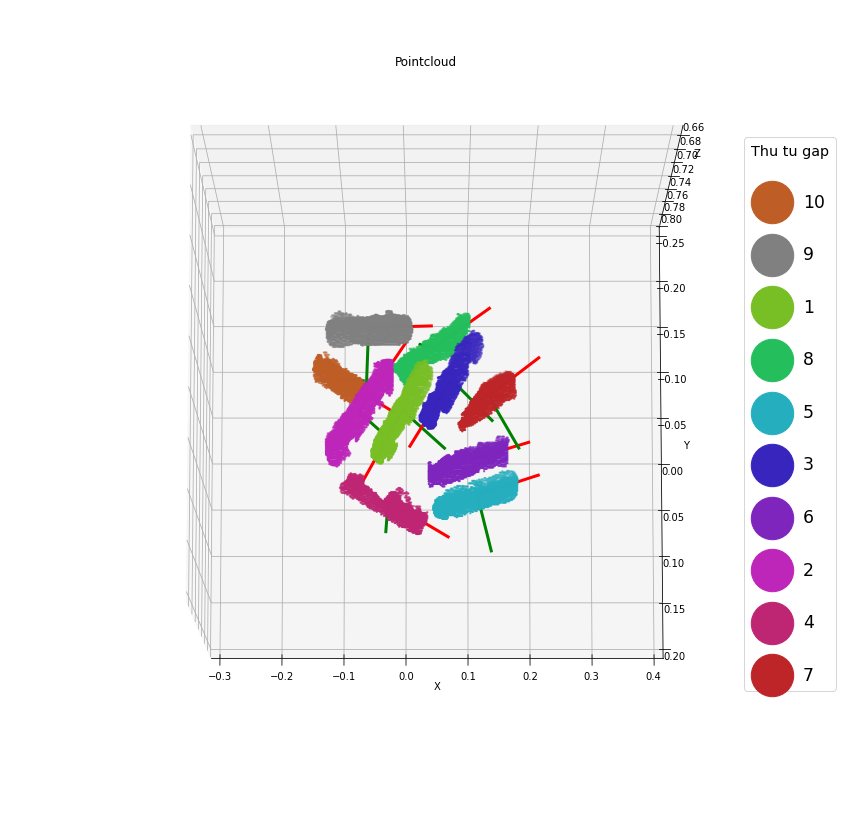

In [ ]:
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
xyz = np.asarray(pcd.points)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-100, -90)   # (-150,30), (-100, -90), (-180,-90)
ax.set_title("Pointcloud")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-0.3,0.4)
ax.set_ylim(-0.25,0.2)
ax.set_zlim(0.65,0.8)

for i in range(10):
  mask = cv2.imread('/content/mask_' + str(i) + '.jpg', 0)
  r, c = np.where(mask==1)
  idx = 640*r + c
  obj = xyz[idx]
  obj_ = []
  # Remove nan values
  for o in obj:
    if str(o[0])=='nan' or str(o[1])=='nan' or str(o[1])=='nan':
      continue
    obj_.append(o)
  obj_ = np.asarray(obj_)
  # Remove outlier
  pcd_obj3 = o3d.geometry.PointCloud()
  pcd_obj3.points = o3d.utility.Vector3dVector(obj_)
  cl, ind = pcd_obj3.remove_statistical_outlier(nb_neighbors=200, std_ratio=1.0)
  #cl, ind = pcd_obj3.remove_radius_outlier(nb_points=100, radius=0.02)
  new_obj = np.asarray(cl.points)
  
  ax.scatter(new_obj[:,0], new_obj[:,1], new_obj[:,2], c = colors_F[i], s = 2.0, label= order_[i]) 
  
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(obj_, mean)
  X = mean[0][0]
  Y = mean[0][1]
  Z = mean[0][2]
  U = X + 0.1*eigenvectors[0][0]
  V = Y + 0.1*eigenvectors[0][1]
  W = Z + 0.1*eigenvectors[0][2]
  #ax.quiver3D(X, Y, Z, U, V, W, length=0.2, normalize=True, color = 'red')
  plt.plot([X,U], [Y,V], [Z, W], c = 'red', linewidth=3)
  X1 = mean[0][0]
  Y1 = mean[0][1]
  Z1 = mean[0][2]
  U1 = X1 + 0.08*eigenvectors[1][0]
  V1 = Y1 + 0.08*eigenvectors[1][1]
  W1 = Z1 + 0.08*eigenvectors[1][2]
  #ax.quiver3D(X1, Y1, Z1, U1, V1, W1, length=0.08, normalize=True, color = 'green')
  plt.plot([X1,U1], [Y1,V1], [Z1, W1], c = 'green', linewidth=3)
  X2 = mean[0][0]
  Y2 = mean[0][1]
  Z2 = mean[0][2]
  U2 = X2 + 0.05*eigenvectors[2][0]
  V2 = Y2 + 0.05*eigenvectors[2][1]
  W2 = Z2 + 0.05*eigenvectors[2][2]
  #ax.quiver3D(X2, Y2, Z2, U2, V2, W2, length=0.05, normalize=True, color = 'blue')
  #plt.plot([X2,U2], [Y2,V2], [Z2, W2], c = 'blue')
ax.legend(markerscale = 30.0, loc = 7, fontsize='xx-large', labelspacing = 2.0, title='Thu tu gap', title_fontsize='x-large')
plt.show()

In [ ]:
# Xac dinh thu tu gap theo do cao dua vao u,v center map voi X,Y,Z trong pointcloud
# Define pick order according to u,v centers map with X,Y,Z in pointcloud
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
xyz = np.asarray(pcd.points)

centers = []
for i in range(10):
  mask = cv2.imread('/content/mask_' + str(i) + '.jpg', 0)
  r, c = np.where(mask==1)
  c_x = int(c.mean())
  c_y = int(r.mean())
  idx = 640*c_y + c_x
  centers.append(xyz[idx])

centers = np.asarray(centers)
order = np.argsort(centers[:, 2])
order_ = {}
for i in range(10):
  order_[order[i]]  = i+1

WARNING - 2021-12-25 03:27:06,893 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:27:07,003 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2021-12-25 03:27:07,105 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array 

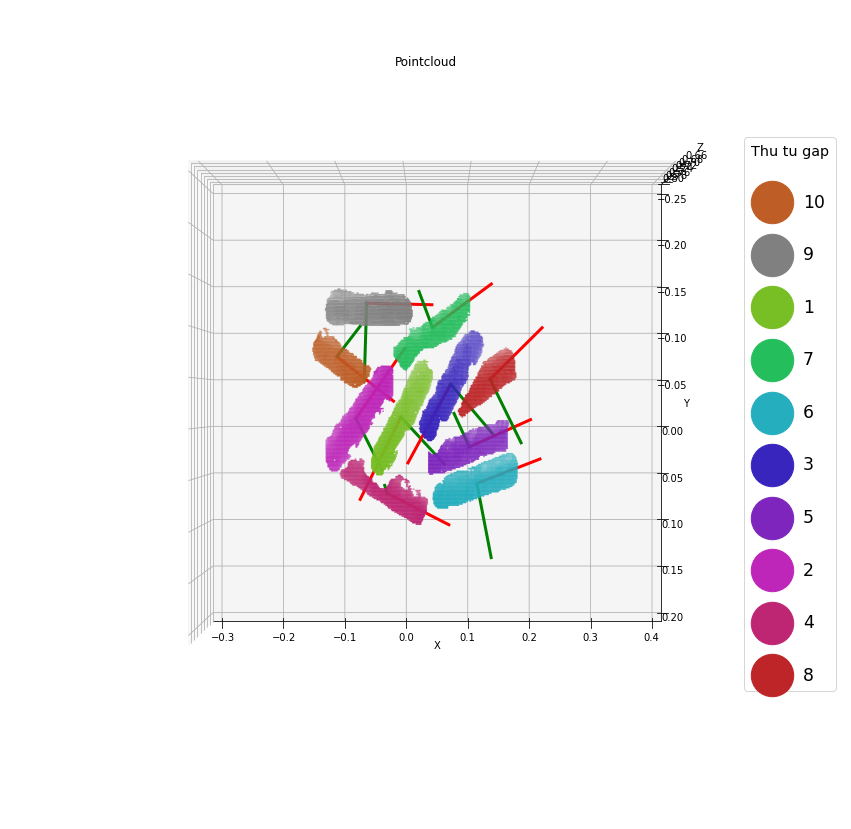

In [ ]:
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd")
xyz = np.asarray(pcd.points)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-90, -90)   # (-150,30), (-100, -90), (-180,-90)
ax.set_title("Pointcloud")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-0.3,0.4)
ax.set_ylim(-0.25,0.2)
ax.set_zlim(0.65,0.8)

for i in range(10):
  mask = cv2.imread('/content/mask_' + str(i) + '.jpg', 0)
  r, c = np.where(mask==1)
  idx = 640*r + c
  obj = xyz[idx]
  obj_ = []
  # Remove nan values
  for o in obj:
    if str(o[0])=='nan' or str(o[1])=='nan' or str(o[1])=='nan':
      continue
    obj_.append(o)
  obj_ = np.asarray(obj_)
  # Remove outlier
  pcd_obj3 = o3d.geometry.PointCloud()
  pcd_obj3.points = o3d.utility.Vector3dVector(obj_)
  cl, ind = pcd_obj3.remove_statistical_outlier(nb_neighbors=200, std_ratio=1.0)
  #cl, ind = pcd_obj3.remove_radius_outlier(nb_points=100, radius=0.02)
  new_obj = np.asarray(cl.points)
  
  ax.scatter(new_obj[:,0], new_obj[:,1], new_obj[:,2], marker = '.', c = colors_F[i], s = 2.0, label= order_[i]) 
  
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(obj_, mean)

  r, c = np.where(mask==1)
  c_x = int(c.mean())
  c_y = int(r.mean())
  idx = 640*c_y + c_x
  mean = xyz[idx]

  X = mean[0] 
  Y = mean[1] 
  Z = mean[2] - 0.05
  U = X + 0.1*eigenvectors[0][0]
  V = Y + 0.1*eigenvectors[0][1]
  W = Z + 0.1*eigenvectors[0][2]
  plt.plot([X,U], [Y,V], [Z, W], c = 'red', linewidth=3)
  
  X1 = mean[0] 
  Y1 = mean[1] 
  Z1 = mean[2] -0.05
  U1 = X1 + 0.08*eigenvectors[1][0]
  V1 = Y1 + 0.08*eigenvectors[1][1]
  W1 = Z1 + 0.08*eigenvectors[1][2]
  plt.plot([X1,U1], [Y1,V1], [Z1, W1], c = 'green', linewidth=3)
  
  X2 = mean[0] 
  Y2 = mean[1] 
  Z2 = mean[2] - 0.05
  U2 = X2 + 0.05*eigenvectors[2][0]
  V2 = Y2 + 0.05*eigenvectors[2][1]
  W2 = Z2 + 0.05*eigenvectors[2][2]
  #plt.plot([X2,U2], [Y2,V2], [Z2, W2], c = 'blue')

ax.legend(markerscale = 60.0, loc = 7, fontsize='xx-large', labelspacing = 2.0, title='Thu tu gap', title_fontsize='x-large')
plt.show()

## PCA calculate 3D Pose of objects with Open3D

Google colab khong the visualize open3d nen thuc hien code nay tren Jupyter notebook + Visual Code

Google Colab can't visualize Open3D. We should  run this code in Jupyter Notebook + Visual Code

In [ ]:
pcd = o3d.io.read_point_cloud("/content/gdrive/MyDrive/OBJECT_DETECT_MASKRCNN/pc1.pcd", remove_nan_points=False, remove_infinite_points=False)

pcd_objs = []
for i in range(10):
  mask = cv2.imread('/content/mask_' + str(i) + '.jpg', 0)
  # map points in pointcloud corresponding with masks of objects
  r, c = np.where(mask==1)
  idx = 640*r + c
  obj = pcd.select_by_index(idx)
  # remove outlier
  cl, ind = obj.remove_statistical_outlier(nb_neighbors=200, std_ratio=1.0)  # Choose approriate parameters
  pcd_objs.append(cl)

# o3d.visualization.draw_geometries(pcd_objs,
#                                   zoom=1.0,
#                                   front=[0.0, -0.2125, -0.8795],
#                                   lookat=[0.0, 0.0, 1.0],
#                                   up=[-0.0694, -0.9768, 0.2024])

centers = []
vectors = []

# PCA calculate 3 axis of objects
for obj in pcd_objs:
    obj_points = np.asarray(obj.points)
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(obj_points, mean) 
    centers.append(mean)
    vectors.append(eigenvectors)
centers = np.asarray(centers)
centers = np.squeeze(centers)
vectors = np.asarray(vectors)

# Create LineSet
points = []
lines = []
line_colors = []
for i in range(10):
    points.append(centers[i])
    for j in range(1,4):
        points.append(centers[i] + 0.1*vectors[i][j-1])
        lines.append([4*i,4*i+j])
    line_colors.append([1, 0, 0])
    line_colors.append([0, 1, 0])
    line_colors.append([0, 0, 1])
points = np.asarray(points)
lines = np.asarray(lines)
points = points.tolist()
lines = lines.tolist()

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(line_colors)

# Visuallize LineSet and Pointcloud of objects
obj_and_frame = pcd_objs
obj_and_frame.append(line_set)
o3d.visualization.draw_geometries(obj_and_frame,
                                  zoom=0.8,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0.0, 0.0, 1.0],
                                  up=[-0.0694, -0.9768, 0.2024])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import scipy
from math import atan2, cos, sin, sqrt, pi, atan
from scipy.spatial.transform import Rotation as R

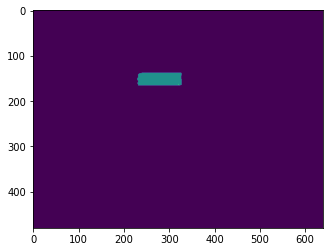

In [ ]:
mask = cv2.imread('/content/mask_1.jpg', 0)
plt.imshow(mask)

In [ ]:
x0 = np.array([1,0,0])
y0 = np.array([0,1,0])
z0 = np.array([0,0,1])
Pose = []
for i in range(vectors.shape[0]):
  x1 = vectors[i][0]
  y1 = vectors[i][1]
  z1 = vectors[i][2]
  Ro = np.array([
                 [np.dot(x1,x0), np.dot(y1,x0), np.dot(z1,x0)],
                 [np.dot(x1,y0), np.dot(y1,y0), np.dot(z1,y0)],
                 [np.dot(x1,z0), np.dot(y1,z0), np.dot(z1,z0)]
                ]
              )
  r = R.from_matrix(Ro)
  yaw, pitch, roll = r.as_euler('ZYX', degrees=True)
  Pose.append([roll, pitch, yaw])
Pose = np.asarray(Pose)
Pose


array([[ -11.0885775 ,    5.47644804,   25.79749297],
       [  -9.31559345,    3.51439478,    0.26031218],
       [   3.6594115 ,    7.35854275, -179.1950002 ],
       [ -12.31608602,   -1.10964627,  -25.68192842],
       [ -22.41951438,   -4.1746556 ,  -14.45630358],
       [   3.07293532,    6.2739908 , -179.06054446],
       [ -11.10157008,   -4.01920797,  -15.55403673],
       [  -6.66498199,    1.79067615,  -44.4653235 ],
       [ 178.77883996,    8.85687014,   12.69509625],
       [ -16.09973425,   -7.70764059,  -33.6551302 ]])

In [ ]:
vectors[2]

array([[-0.61499633,  0.7786039 , -0.12472166],
       [ 0.78851983,  0.60804924, -0.09226379],
       [-0.00399996,  0.15508739,  0.98789266]])

In [ ]:
np.arctan2(0.7786039, -0.61499633)*180/np.pi

128.30417026039643

# DOCUMENT

## Mask RCNN

https://github.com/matterport/Mask_RCNN

https://towardsdatascience.com/mask-rcnn-implementation-on-a-custom-dataset-fd9a878123d4

https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/

https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/


## Open3D 

http://www.open3d.org/docs/release/tutorial/geometry/pointcloud.html 

http://www.open3d.org/docs/release/tutorial/geometry/file_io.html

http://www.open3d.org/docs/release/tutorial/geometry/pointcloud_outlier_removal.html

http://www.open3d.org/docs/release/tutorial/geometry/working_with_numpy.html

http://www.open3d.org/docs/release/tutorial/visualization/index.html

## PCA

https://learnopencv.com/principal-component-analysis/

https://www.jeremyjordan.me/principal-components-analysis/

https://analyticsindiamag.com/detecting-orientation-of-objects-in-image-using-pca-and-opencv/

https://docs.opencv.org/3.4/d1/dee/tutorial_introduction_to_pca.html

## Blender

Create Synthetic Data:
https://www.youtube.com/watch?v=xeprI8hJAH8&list=PLq7npTWbkgVAt4cnrsEzouM6kDKySnkRI

Gravity:
https://www.youtube.com/watch?v=-4uFt0m5I-U

Particle System
https://www.youtube.com/watch?v=TWZgMg56YMQ
https://www.youtube.com/watch?v=pg12Od0aS4U
